# Problem Set 5 - Unsupervised Learning and Reinforcement Learning
## CSCI 5622 - Spring 2023

***
**Name**: Peter Rock
***

This assignment is due on Canvas by **11.59 PM on Friday, April 28**.
Submit only this Jupyter notebook to Canvas. Do not compress it using tar, rar, zip, etc.
The last bonus problem will require additional files to be submitted. We'll explain its submission format later.

Your solutions to analysis questions should be done in Markdown directly below the associated question.
Remember that you are encouraged to discuss the problems with your classmates and instructors,
but **you must write all code and solutions on your own**, and list any people or sources consulted.

In [1]:
#!pip install -r requirements.txt #uncomment to install all required packages
import numpy as np
import matplotlib.pyplot as plt
import helpers
import data

## Setup

For our K-means problem, we'll be using three synthetic datasets plotted below. From left to right: co-centric circles `circles`, blobs with 4 centers `multi_blobs`, and blobs with 2 centers `binary_blobs`.

Each of the dataset instances has (`X`, `labels`) attributes that are split into `train` and `test` partitions.
In the first problem, we'll be implementing K-means and evaluate it on the `binary_blobs` and `multi_blobs` data. the Bonus section will work on trying to get K-Means to adapt to the `circles` problem.

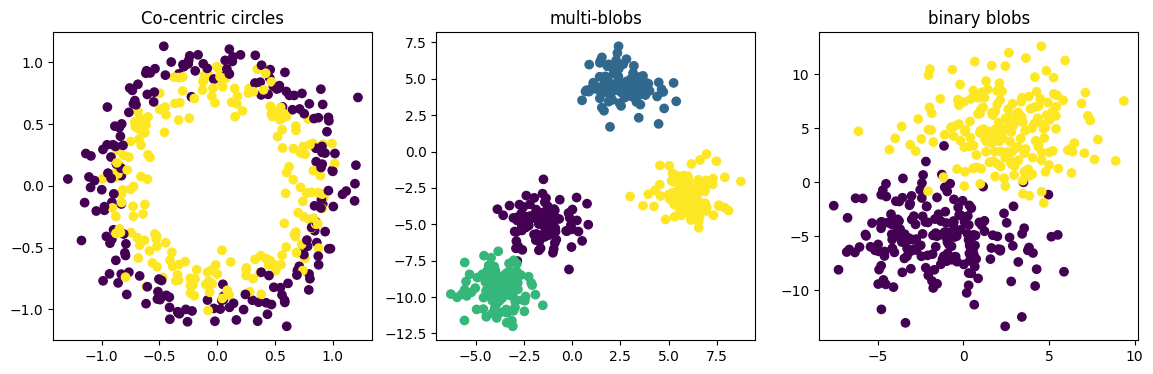

In [2]:
%matplotlib inline
# Do not modify this cell
circles = data.Circles()
circles_offset = data.Circles()
multi_blobs = data.DataBlobs(centers=4, std=1.)
binary_blobs = data.DataBlobs(centers=2, std=2.7)

fig, axs = plt.subplots(1, 3)
fig.set_figheight(4), fig.set_figwidth(14)
for i, (dataset, name) in enumerate([(circles, "Co-centric circles"),
                                     (multi_blobs, "multi-blobs"),
                                     (binary_blobs, "binary blobs")]):
    axs[i].set_title(name)
    axs[i].scatter(dataset.X[:, 0], dataset.X[:, 1], c=dataset.labels)
plt.show()

# Problem 1 : K-means (34 points)

The goal of K-means is to partition the data into $k$ clusters such that the sum of intra-cluster variances is minimal.
We will be using Euclidean distance as our variance measure, so for cluster $C_i = \{x_1,x_2,... x_{m_i}\}$, its intra-cluster variance $V(C_i)$ is defined as:

$$
V(C_i) = \sum_{j=1}^{m_i} ||x_j - \mu_i||^2
$$

where $\mu_i = \frac{1}{m} \sum_{i=1}^{m_i} x_i$. $\mu_i$ is called the centroid of cluster $C_i$.

So for $k$ clusters, K-means objective is:
$$
\min_{C_1,C_2\ldots C_k}\sum_{i=1}^{k}V(C_i) = \min_{C_1,C_2\ldots C_k} \sum_{i=1}^{k} \sum_{j=1}^{m_i} ||x_j - \mu_i||^2
$$

Each sample $x_i$ is assigned to the cluster of the closest centroid. Hence, finding the optimal partition $\{C_1,C_2...C_k\}$ that minimizes the objective is equivalent to finding the optimal centroids.

Unfortunately, there is no algorithm that reaches the global optima for K-means, but we'll be implementing the most famous heuristic for the problem: Llyod algorithm. It works as follows:

- Initialize the centroids with **unique** random samples (`initialize_centroids`), initial objective = $+\infty$
- Repeat until convergence:
    - Compute the distances matrix $D$ between samples and centroids (`compute_distances`)
    - Use $D$ to assign each sample to the cluster with the closest centroid (`computes_assignments`)
    - Update the centroids as centers of the new cluster assignments (`compute_centroids`)
    - Compute the new objective (`compute_objective`)
    - Stop if the improvement ratio of the objective is less than $\epsilon$

The improvement ratio equal to `|new_objective - previous_objective|/|previous_objective|`.


- **1.1 [2 points]** `initialize_centroids` : select K **distinct** samples from the matrix data `X` and use them as the initial centroids. Store these centroids in the class attribute `self.centroids` as an `np.array` of shape $k \times d$.
- **1.2 [4 points]** `compute_distances` : compute the distance of each sample $x_i$ to every centroid $c_j$ and return the result as a matrix `distances_matrix` of size $N \times k$ where `N` is the number of samples and `k` is the chosen number of clusters to be found. The cell `(i,k)` shall contain the euclidean distance between sample $x_i$ and centroid $m_k$.
- **1.3 [2 points]** `compute_assignments` : given the distances matrix of size $N \times k$ return an array of labels in which each element is an integer in the range $[0, k-1]$ and it represents which centroid it's closest to.
- **1.4 [4 points]** `compute_centroids` : Compute the new centroids depending on the new set of samples that has been alloted to each cluster.
- **1.5 [6 points]** `fit` : This shall contain your main loop which implements the algorithm described above. You'll sequentially call the methods above to find the $k$ centroids. Break the loop when the improvement ratio of the objective is within `rtol`. At the end (or start, depending on how you code it) of each iteration, call the method `save_plot` to save the current clustering status and save the current objective value in the `history` list.
- **1.6 [3 points]** `predict` : Given new samples, return their assigned clusters that were learned in the `fit` step.

While we're working on 2-d data (d=2) for visualization purposes, your implementation should handle any number of features.

In [34]:
from sklearn.metrics.pairwise import euclidean_distances


class KMeans:
    def __init__(self, k, rtol=1e-3):
        """
        :param k: (int) number of means/centroids to evaluate
        :param rtol: (float) relative tolerance, `epsilon` from the markdown
        """
        self.k = k
        self.centroids = None
        self.snapshots = []  # buffer for progress plots
        self.rtol = rtol

    def initialize_centroids(self, X):
        """
        Randomly select k **distinct** samples from the dataset in X as centroids
        @param X: np.ndarray of dimension (num_samples, num_features)
        @return: centroids array of shape (k, num_features)
        """
        centroids = None
        # Workspace 1.1
        #BEGIN 
        rand_idxs = np.random.choice(len(X), self.k, replace= False)
        self.centroids = X[rand_idxs, :]
        centroids = self.centroids
        
        # centroids = X[np.random.choice(X.shape[0], self.k, replace = False)]
        # code here
        #END
        return centroids

    def compute_distances(self, X):
        """
        Compute a distance matrix of size (num_samples, k) where each cell (i, j) represents the distance between
        i-th sample and j-th centroid. We shall use Euclidean distance here.
        :param X: np.ndarray of shape (num_samples, num_features)
        :return: distances_matrix : (np.ndarray) of the dimension (num_samples, k)
        """
        distances_matrix = np.zeros((X.shape[0], self.k))
        # Workspace 1.2
        #BEGIN 
        distances_matrix = euclidean_distances(X, self.centroids)
        #END
        return distances_matrix

    @staticmethod
    def compute_assignments(distances_to_centroids):
        """
        Compute the assignment array of shape (num_samples,) where assignment[i] = j if and only if
        sample i belongs to the cluster of centroid j
        :param distances_to_centroids: The computed pairwise distances matrix of shape (num_samples, k)
        :return: assignments array of shape (num_samples,)
        """

        assignments = np.zeros((distances_to_centroids.shape[0],))

        # Workspace 1.3
        #BEGIN 
        assignments = np.argmin(distances_to_centroids, axis= 1)
        #END
        return assignments

    def compute_centroids(self, X, assignments):
        """
        Given the assignments array for the samples, compute the new centroids
        :param X: data matrix of shape (num_samples, num_features)
        :param assignments: array of shape (num_samples,) where assignment[i] is the current cluster of sample i
        :return: The new centroids array of shape (k, num_features)
        """
        # Workspace 1.4
        centroids = np.zeros((self.k, X.shape[1]))
        #BEGIN 
        # code here
        for i in range(self.k):
            new_points = X[assignments == i]
            centroid = np.sum(new_points, axis = 0) / new_points.shape[0]
            centroids[i] = centroid
        #END
        return centroids

    def compute_objective(self, X, assignments):
        return np.sum(np.linalg.norm(X - self.centroids[assignments], axis=1) ** 2)

    def fit(self, X):
        """
        Implement the K-means algorithm here as described above. Loop until the improvement ratio of the objective
        is lower than rtol. At the end of each iteration, save the k-means objective and return the objective values
        at the end

        @param X:
        @return:
        """
        self.centroids = self.initialize_centroids(X)
        objective = np.inf
        assignments = np.zeros((X.shape[0],))
        history = []

        # Workspace 1.5

        while True:
            self.save_snapshot(X, assignments)
            #BEGIN 
            distances = self.compute_distances(X)
            assignments = self.compute_assignments(distances)
            self.centroids = self.compute_centroids(X, assignments)
            new_objective = self.compute_objective(X, assignments)
            history.append(new_objective)
            
            if abs(objective - new_objective) < self.rtol:
                break
            
            objective = new_objective
            #END
        return history

    def predict(self, X):
        # Workspace 1.6
        assignments = np.zeros((X.shape[0],))
        #BEGIN 
        distances = self.compute_distances(X)
        assignments = self.compute_assignments(distances)
        #END
        return assignments

    def save_snapshot(self, X, assignments):
        """
        Saves plot image of the current assignments
        """
        if X.shape[1] == 2:
            self.snapshots.append(helpers.create_buffer(X, assignments))

In [35]:
%matplotlib notebook
# show progress code
np.random.seed(2023)
k_means = KMeans(4)
objective_history = k_means.fit(multi_blobs.X)
helpers.show_progress(k_means.snapshots)

## Evaluating K-means
The easiest way to evaluate the clustering quality is to use the true labels. The natural question here is: which cluster corresponds to which label?

Let's first formulate the question using `multi_blobs` dataset. We have 4 clusters and 4 classes in our data. Let's create a _confusion matrix_ $C$ between the clusters and the labels so that $ C_{i,j} = \text{size}(\text{cluster}_i \cap \text{class}_j)$.

We model the unknown mapping using the $4\times 4$ boolean matrix $X$ such that $X_{i,j}=1$ if and only if $\text{cluster}_i$ is mapped to $\text{class}_j$.

To avoid having a cluster assigned to multiple classes, each row of $X$ is constrained to have only one non-zero entry.

Now, given a mapping $X$ and confusion matrix $C$, the number of correctly "classified" samples (not really classification, more of clustering here) is:

\begin{align}
\#\text{correct} = \sum_i \sum_j C_{i,j} X_{i,j}
\end{align}
The goal is to find $\hat{X}$ that maximizes $\#\text{correct}$. To solve for $X$ we're going to use `scipy`'s `linear_sum_assignment`
([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html)) just like we did in Problem Set 1(?).

- **1.7 [5 points]** Complete `evaluate_clustering` to return the accuracy of K-means using the optimal mapping $\hat{X}$
defined above.

In [ ]:
from scipy.optimize import linear_sum_assignment


def evaluate_clustering(trained_model, X, labels):
    """
    Compute the ratio of correct matches between clusters from the trained model and the true labels
    :param trained_model: Unsupervised learning model that predicts clusters
    :param X: samples array, shape (num_samples, num_features)
    :param labels: true labels array, shape (num_samples,
    :return:
    """
    # We can assume that the number of clusters and the number of class labels are the same
    clusters = trained_model.predict(X)
    # Workspace 1.7
    #BEGIN 
    # code here
    #END
    return accuracy

- **1.8 [4 points]** Run K-means on the full `multi_blobs` for 20 times. Plot the histogram (`plt.hist`) of the clustering evaluation from `evaluate_clustering`. Also report the mean clustering performance

In [ ]:
%matplotlib inline
accuracies = []
# Workspace 1.8
#BEGIN 
# code here
#END


## K-means++
We have used a random centroid initialization in K-means. In K-means++, we initialize the centroids
in a (slightly) smarter way, and it works as the following:
- Choose the first centroid uniformly at random from the data samples
- For the subsequent centroids:
    - compute the distances $(d_i)$ between the data samples and the current centroids (distance between a sample and its nearest centroid)
    - Pick a new centroid randomly with probability proportional to $d_i ^2$ (not $d_i$!).


The rest of _K-means++_'s algorithm is exactly the same as _K-means_

- **1.9 [4 points]**  Complete the `initialize_centroids` of K-means++ class and report K-means++ performance in a similar way to 1.8. Which model is better?

 You do not have to implement other methods. `KMeansPP(Kmeans)` implies that `KMeansPP` will inherit all the methods of `Kmeans` unless we choose to _override_ them (redefinition).

_Hint_: The weighted sampling can be done using `numpy`'s `choice` and its argument `p`. You do not have to worry about excluding the already picked centroids from the data. Once they're picked, their sampling weight should be equal to $0$. Make sure the probabilities sum to $1$.


In [ ]:
class KMeansPP(KMeans):

    def initialize_centroids(self, X):
        #Workspace 1.9.a
        # Complete K-means++ centroid initialization. The first step (first centroid) is provided in the next line
        # Hint: You can modify self.centroids and use self.compute_distances to avoid re-coding distances computations
        centroids = X[np.random.choice(range(X.shape[0]), size=1)]
        #BEGIN 
        # code here
        #END
        return centroids

In [ ]:
%matplotlib notebook
k_means_pp = KMeansPP(4)
objective_history = k_means_pp.fit(multi_blobs.X)
helpers.show_progress(k_means_pp.snapshots)

In [ ]:
%matplotlib inline
accuracies = []
# Workspace 1.9.b
# Redo 1.8 using KMeansPP
#BEGIN 
# code here
#END

### Workspace 1.9.c
% Which model is better?

% BEGIN

% END

# Problem 2: Topic Modeling [20 pts]

Just like in Problem Set 3, we're going to work with the IMDB Movie Review Dataset. This time, however, we are looking for unique clusters of similar reviews and seeing how that correlates with our positive and negative reviews status.

In [ ]:
import data
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem.porter import *

nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
imdb = data.IMDB()
print(f"[Example: {imdb.X_train[1][:157]}], label:{imdb.y_train[1]}")

- **2.1 [4 pts]** Complete the clear_stopwords function to pull out all tokens found in the self.stopwords set.
- **2.2 [4 pts]** Complete the clear_punct function to pull out all tokens found in the self.punctuations set.
- **2.3 [4 pts]** Complete the count_matrix function to convert the ragged 2d array of token lists for each document into a (words * documents) rectangular array of word-document counts.
- **2.4 [4 pts]** Complete the tfidf_transform function to convert the count of each word-document entry into its tf-idf score, then min-max scale the data to the boundaries of \[0,1\].

In [ ]:
class TFIDF_Transformer():
    def __init__(self):
        self.stopwords = set(stopwords.words('english'))
        self.punctuations = set(string.punctuation)

    def tokenize(self, data):
        result = []
        #returns a 2d ragged array (documents * words) of word (and punctuation) tokens found in 'data' using the NLTK word_tokenizer
        for doc in data:
            result.append(word_tokenize(doc))
        return result

    def clear_stopwords(self, data):
        #2.1 - Remove stopwords from 'data' that are found in the self.stopwords list

        result = []
        # Workspace 2.1
        #BEGIN 
        # code here
        #END
        return result

    def clear_punct(self, data):
        #2.2 - Remove punctuations from 'data' that are found in the self.punctuations list
        #NOTE: Do not remove punctuation embedded within a larger word string.
        result = []
        # Workspace 2.2
        #BEGIN 
        # code here
        #END
        return result

    def stem(self, data):
        #returns an array of stemmed words found in data using the NLTK Porter Stemmer

        result = []
        stemmer = PorterStemmer()
        for doc in data:
            result.append([stemmer.stem(word) for word in doc])

        return result

    def count_matrix(self, data):
        #2.3 - Generate a rectangular array (unique words * documents) with the word-document count in each cell

        mat = np.array([])  #should become a (words * documents) 2d array
        # Workspace 2.3
        #BEGIN 
        # code here
        #END
        return mat

    def tfidf_transform(self, data):
        #convert from a matrix of word-document counts to a tf-idf matrix
        #NOTE: Min-Max scale the resulting TF-IDF scores to [0-1] before returning
        result = []
        # Workspace 2.4
        #BEGIN 
        # code here
        #END
        return result

    def transform(self, data):
        # tokenize, clear stopwords, clear punctuation, and stem your data
        data = self.tokenize(data)
        data = self.clear_stopwords(data)
        data = self.clear_punct(data)
        data = self.stem(data)

        # convert from word lists for each document to a tf-idf words * documents matrix
        data = self.count_matrix(data)
        data = self.tfidf_transform(data)
        return data  #%% md


In [ ]:
transformer = TFIDF_Transformer()
tfidf = transformer.transform(imdb.X_train)

- **Q2.5 [4pts]** Use your KMeans implementation to evaluate the clustering performance on IMDB dataset, similar to 1.8

In [ ]:
# Workspace 2.5
#BEGIN 
# code here
#END

In [ ]:
import numpy as np
import helpers
import tqdm.notebook
import matplotlib.pyplot as plt
import gym

## Problem 3: Reinforcement Learning [46pts + 5pts]

The environments in this problem are from OpenAI's `gym` library. We will be using the classic control module.

Let's start by getting familiar with our initial environment. Note that each environment can have its own unique settings. Refer to the documentation for more information https://www.gymlibrary.dev/



In [ ]:
# setting is_slippery is false, removes randomness from the transitions.
# the render mode is chosen so that env.render() returns the captures of all previous steps
lake_env = gym.make("FrozenLake-v1", render_mode="rgb_array_list", is_slippery=False)
# We start by resetting the environment to get the initial state
state, _ = lake_env.reset()
plt.imshow(lake_env.render()[-1])


We'll be using the Frozen Lake environment where the goal of the agent  is to reach the target while avoiding the holes.

The grid is 4 by 4, so there are 16 states. Not all the states are accessible, since the agent can't cross the holes.
The states are represented by the integers 0 to 15, from left to right, top down. The initial state is 0 and the target at 15.

There are 4 possible actions at each state (clockwise): Left(0), Down(1), Right(2), Up(3).

We get a reward of 1 when we reach the target, and 0 otherwise.


In [ ]:
# show the action space
print(lake_env.action_space)
# sample random action
print(lake_env.action_space.sample())

The game ends when we reach the goal or when we fall in the hole.

At step $t$, the agent is located at state $s_t$ and chooses an action $a_t = \pi(s_t)$ following a policy $\pi$

The agent then gets reward $r_t$ and moves to state $s_{t+1}$. The process repeats until we reach a final state $s_T$ (`terminated == True`)

We'll call a replay a sequence of tuples $(s_t, a_t, r_t, s_{t+1})$.

In [ ]:
state, _ = lake_env.reset()
# We take the action Down, 1
action = 1
next_state, reward, terminated, _, _ = lake_env.step(action)
print(f"initial state:{state}, new state {next_state}")
print(f"current replay {[(state, action, reward, next_state)]}")
# render return the screen captures of the episode, we want to examine the last frame
plt.imshow(lake_env.render()[-1])

- **Q3.1 [3pts]** Complete `UniformPolicy`'s act to return a uniformly sampled action from the action space.

In [ ]:
class UniformPolicy:
    def __init__(self, env: gym.Env):
        self.env = env

    def act(self, state):
        action = 0
        # Workspace 3.1
        #BEGIN 
        # code here
        #END
        return action


Given a certain policy, we will play the game following the actions from the policy until the game ends.


- **Q3.2 [5pts]** Complete `get_episode` to return the replay of a single episode (from the moment we reset the game until it terminates)

It is a good practice to set the reward to -1 at the moment the game ends without reaching the goal.


In [ ]:
def get_episode(environment, policy):
    """
    :param environment: gym.Env instance
    :param policy: a policy with method act that takes a state and returns an action
    :return: Return one episode replay using policy
    """
    episode = []
    current_state, _ = environment.reset()
    terminated = False
    while not terminated:
        # Workspace 3.2
        #BEGIN 
        # code here
        #END
    return episode

- **Q3.3 [3pts]** Generate a replay of 500 episodes using the uniform policy

In [ ]:
n_ep = 500
replay = []
# Workspace 3.3
#BEGIN 
# code here
#END
# length around 4000 +/- 300
print(len(replay))

## Value Iteration
Starting at time $t=0$, The agent's goal is to maximize the expected discounted rewards:
\begin{align}
\eta_\pi = \sum_{t | a_t =\pi(s_t)} \gamma^t r_t
\end{align}
$0<\gamma<1$ is the discount rate. We'll be using $\gamma = 0.5$

We want to learn the value function $V$. $V_\pi(s)$ is defined as the expected discounted rewards if we start from state $s$ and follow the policy $\pi$.
\begin{align}
V_\pi(s) = \eta_\pi, \text{ such that } s_0 = s
\end{align}

To learn $V$ of the optimal policy, we use the value iteration algorithm for a deterministic environment:
- Initialize $V(s)=0, \forall s$, absolute difference parameter $d$, learning rate $\alpha$
- Repeat
    - for each $s$ in state space
        - $v \leftarrow V(s)$
        - $v* = 0$
        - for each possible action $a$ and next state $s'$
            - $v* \leftarrow \max(v*, r + \gamma V(s'))$
        - $V(s) \leftarrow v*$
        - $\Delta \leftarrow max(\Delta, |v - V(s)|)$
- until $\Delta < d$


**Q3.4[6pts]** Complete the class method `TabularV.update` to implement the value iteration given a replay.
Your solution doesn't have to be generic. You can assume that we'll only use it on the FrozenLake environment.

In [ ]:
class TabularV:
    def __init__(self, gamma=0.5, d=0.06):
        """
        :param gamma: discount rate
        :param d: absolute difference used to stop the iterations
        """
        self.V = np.zeros((16,))
        self.gamma = gamma
        self.d = d

    def update(self, replay):
        n_iterations = 0
        # Workspace 3.4
        #BEGIN 
        # code here
        #END


In [ ]:
# Visualize the value function
V = TabularV()
V.update(replay)
helpers.display_matrix(V.V.reshape(4, 4))

- **Q3.5 [2pts]** How many iterations did it take for the algorithm to terminate?

#### Workspace 3.5

#BEGIN

% YOUR ANSWER HERE

#END


- **Q3.6 [3pts]** How would we build the optimal policy based on the value function above?

#### Workspace 3.6

#BEGIN

% YOUR ANSWER HERE

#END


## Deep Q Learning


We will use the [cart pole game](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) for our Q Learning.
We get a reward = 1 whenever the pole is upright, less than 24 degrees from the vertical line.

In [ ]:
pole_env = gym.make("CartPole-v1", render_mode="rgb_array_list")
# We start by resetting the environment to get the initial state
state, _ = pole_env.reset()
plt.imshow(pole_env.render()[-1])
print(state)

- **Q3.7 [3pts]** What is the set of actions and the set of possible states?

#### Workspace 3.7


#BEGIN

% YOUR ANSWER HERE

#END


In [ ]:
pole_env.reset()
terminated = False
while not terminated:
    action = pole_env.action_space.sample()
    _, _, terminated, _, _ = pole_env.step(action)
# save the episode's frame as video file
helpers.save_frames(pole_env.render(), "random_pole")
# display the video file
helpers.display_video("random_pole")

In the previous environment, to determine the policy using Value iteration, we had to know the transition mechanics, have a finite set of states and know all the possible actions at every state.

With Q Learning, none of these elements is required, hence the characterisation of this method as __model-free__.

$Q_\pi(s_t, a_t)$ is defined as the expected discounted rewards if we start at state $s_t$, take an initial actions $a_t$, and
follow the policy $\pi$ to decide the remaining action $(a_{t+1},..... a_{T-1})$.

\begin{align}
Q_\pi(s,a) = \eta_\pi, \text{ such that } s_0 = s \text{ and } a_0 = a
\end{align}

Since at each instant $t$, we want to pick the action that yields the best expected rewards, the optimal policy based on Q, $\pi^*$ would be:
\begin{align}
\pi^*(s) = \arg\max_a Q^*(s, a),
\end{align}
also known as the greedy policy.

__So how do we learn the optimal $Q^*$?__

we can use _Bellman equations_ to update our estimate of the $Q$ function in the following way:
\begin{align}
Q_{new}(s_t, a_t) \leftarrow r_t + \gamma \max_a Q_{old}(s_{t+1}, a), \;\;\; \forall \; (s_t, a_t, r_t, s_{t+1})\in \text{Replay}
\end{align}

We can prove that repeating this update will make our estimate converge to a unique optimal state-action value function $Q^*$.


In Deep Q learning, we model Q as neural network $Q_\theta$ where $\theta$ represent the network parameters.
The neural network takes the states as input and outputs a 2-dimensional array $Q(s)$.

Given a replay $Replay$, we will call an iteration:
- Get the current $Q$ values of the states $s_t$ : `Q_s`
- Get the current $Q$ values of the states $s_{t+1}$: `Q_s_p`
- Updates the element of `Q_s` following __Bellman__ method (you'll have to use `Q_s_p`, the replay actions and the rewards)
- Fit the neural network using the replays states and the computed `Q_s` for a single epoch

A single update might consist of several iterations ( do not confuse this with the neural network fit's epoch)

We'll be minimizing the objective
\begin{align}
    \mathcal{L}_\theta(\text{Replay}) = \sum_{(s_t, a_t, r_t, s_{t+1}) \in \text{Replay}} \mathcal{L}\big(Q_{\theta}(s_t, a_t) - \big[r_t + \gamma \max_a Q_\theta(s_{t+1}, a) \big] \big)
\end{align}
where $\mathcal{L}$ is a loss function.

In our implementation, we'll be using `Huber` loss. You're free to change the loss, the learning rate, and the network architecture. The ones provided bellow have been tested, and they're guaranteed to work

- **Q3.8 [4pts]** Complete DeepQ's initialization to build a network that takes 4 features as inputs and maps them to 2 outputs.
- **Q3.9 [10pts]** Complete DeepQ's update to perform _Bellman_ iterations

In [ ]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses


class DeepQ:
    def __init__(self, gamma=0.5):
        self.neural_net = models.Sequential([layers.InputLayer(input_shape=(4,)),
                                             # Workspace 3.8
                                             #BEGIN 
                                             # code here
                                             #END
                                             layers.Dense(2)])  # Do not change the model
        optimizer = optimizers.adam_v2.Adam(learning_rate=1e-3)  # You can change the learning rate
        self.neural_net.compile(loss=losses.Huber(), optimizer=optimizer)  # You can also change the loss function
        self.neural_net.summary()
        self.gamma = gamma

    def update(self, replay, epochs=2, batch_size=32):
        current_states = np.array([r[0] for r in replay])
        actions = np.array([r[1] for r in replay])
        rewards = np.array([r[2] for r in replay])
        next_states = np.array([r[3] for r in replay])
        loss = 0
        for _ in range(epochs):
            # Workspace 3.9
            # Todo: predict Q_s and Q_s_p
            # Use Q_s_p, actions, rewards to update Q_s and fit self.neural_network for one epoch
            # Q_s = None

            #BEGIN 
            # code here
            #END
            history = self.neural_net.fit(current_states, Q_s, epochs=1, batch_size=batch_size)
            loss += history.history["loss"][0]
        print("Loss:", loss / epochs)

    def best_action(self, s):
        # We want to allow some noise in the estimation
        q = self.neural_net.predict(s[None, :])[0]
        return np.argmax(q)

    def checkpoint(self, checkpoint_path):
        self.neural_net.save_weights(checkpoint_path)

    def load(self, checkpoint_path):
        self.neural_net.load_weights(checkpoint_path)


Now we have to address a different question: when we explore the environment, how should we choose the actions?

One approach is to follow a $\epsilon$-greedy policy, where we choose a random action with probability $\epsilon$ and the best action according to Q with probability $1-\epsilon$.

For instance, if $\epsilon=1$, all actions are chosen randomly. For $\epsilon=0$, all actions are chosen _greedily_.
A common practice is to start with $\epsilon=1$ and decay it to 0 as we generate replays. How fast we decay it is related to the famous _exploration-exploitation_ dilemma in Reinforcement Learning.

- **Q3.10[3pts]** Complete `EpsilonGreedy.act` to return a uniformly random action with probability $\epsilon$ and the best action with probability $1-\epsilon$


In [ ]:
class EpsilonGreedy():

    def __init__(self, env: gym.Env, Q: DeepQ, initial_epsilon=1):
        self.Q = Q
        self.env = env
        self.epsilon = initial_epsilon

    def act(self, state):
        action = None
        # Workspace 3.10
        #BEGIN 
        # code here
        #END


In [ ]:
deep_Q = DeepQ()
greedy_policy = EpsilonGreedy(pole_env, deep_Q, initial_epsilon=1.0)
# Tweak the next parameters to improve the learning
# You can also tweak the learning rate and the neural network
n_iterations = 10
steps_per_replay = 1200
decay = 0.8

In [ ]:
# Make sure to limit the prints, otherwise the notebook might become too large
for e in range(n_iterations):
    replay = []
    pbar = tqdm.notebook.tqdm(desc="Generating replay", total=steps_per_replay)
    episodes_lengths = []
    while len(replay) < steps_per_replay:
        ep = get_episode(pole_env, greedy_policy)
        episodes_lengths.append(len(ep))
        replay += ep
        pbar.update(len(ep))
    pbar.close()
    print("iteration", e + 1, "/", n_iterations, ", eps:", greedy_policy.epsilon, ", average episode length:",
          np.mean(episodes_lengths))

    deep_Q.update(replay, epochs=1)
    greedy_policy.epsilon *= decay

**Q3.11[4pts]** To be considered for full credit, include `deep_q.mp4` and the `checkpoint` folder in your submitted `q_learning.zip`

We expect an episode length > 40.

In [ ]:
frames = []
deep_best_policy = EpsilonGreedy(pole_env, deep_Q, initial_epsilon=0)
total_lengths = 0
for _ in range(10):
    total_lengths += len(get_episode(pole_env, deep_best_policy))
    frames += pole_env.render()
print("avg len of episodes:", total_lengths / 10)
helpers.save_frames(frames, "deep_q")

In [ ]:
helpers.display_video("deep_q")

In [ ]:
deep_Q.checkpoint("checkpoint/deep_q")

**Q3.12[Bonus, 5pts]** If the average episode length is > 100
